# Convolution NN for first break picking

First-break picking is the task of determining, given a set of raw seismic traces, the onsets of the first signal arrivals as accurately as possible. The accurate determination of the first arrivals onset first-break times is needed for calculating the static corrections, a fundamental stage of seismic data processing.

* [Datasets](#Datasets)
* [Model architecture](#Model-Architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Running time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)

## Datasets

We exploit raw traces from Vor dataset as training examples. We will test our model on the Vor traces from seismofields, the model did not see during training. All datasets descriptions are avaliable [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/first_break_picking.ipynb).

| Filename | About this file | Size | N ffid | Length |
| :------ | ----: | ----: | ----: | ----: |
| 3_FBP_1k-ffid_3s.sgy | Raw field seismogram | 2.4 Gb | 50 | 2. s |
| 3_FBP_1k-ffid_3s.sgy_picking.csv | First break time | 10 Mb | 50 | - |

In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../../..')

from seismicpro.batchflow import Dataset, B, V, W
from seismicpro.batchflow.models.torch import UNet
from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex, 
                           seismic_plot, KNNIndex, SeismicDataset)
from seismicpro.models.metrics import PickingMetrics

Index field records with FB time as a separate column:

In [26]:
path_raw = '/data/FB/dataset_6/3_FBP_input_ffid_raw-500_off-800.sgy'
markup_path = '/data/FB/dataset_6/3_FBP_manual_flatiron_picking.csv'

index = KNNIndex(name='raw', path=path_raw, markup_path=markup_path, n_neighbors=5)

Seismic index functionality allows us to easily convert one type of index to another. See the tutotial for [details](https://github.com/analysiscenter/SeismicPro/blob/dev/tutorials/1.Index.ipynb).

In [27]:
findex = FieldIndex(index)
findex.head()

,KNN,CDP_X,FIRST_BREAK_TIME,CDP_Y,TraceNumber,TRACE_SEQUENCE_FILE,file_id
,,,,,,raw,raw
FieldRecord,,,,,,,
155800,0,508234,256.215240,7017796,1140,1,/data/FB/dataset_6/3_FBP_input_ffid_raw-500_of...
155800,0,508252,260.276031,7017814,1141,2,/data/FB/dataset_6/3_FBP_input_ffid_raw-500_of...
155800,0,508216,256.082855,7017778,1139,3,/data/FB/dataset_6/3_FBP_input_ffid_raw-500_of...
155800,0,508269,265.236664,7017831,1142,4,/data/FB/dataset_6/3_FBP_input_ffid_raw-500_of...
155800,0,508199,277.678772,7017761,1138,7,/data/FB/dataset_6/3_FBP_input_ffid_raw-500_of...


Selecting field records and traces for model training. We use 90% of the traces as training exampes. The rest is for test.

In [4]:
train_index = KNNIndex(findex.create_subset(findex.indices[:40]))
train_data = SeismicDataset(train_index)

In [5]:
test_index = KNNIndex(findex.create_subset(findex.indices[40:]))
test_data = SeismicDataset(test_index)

## Model Architecture

We are using 1D Unet type of model with 5 blocks.

Model's configuration:      
* upsample: ConvTranspose1d - BatchNorm - Relu   
* downsample: MaxPool1d
* encoder block: Conv1d - BatchNorm - Relu - Conv1d - BatchNorm - Relu - downsample
* decoder block: upsample - Conv1d - BatchNorm - Relu - Conv1d - BatchNorm - Relu   
* head: Conv1d

Layes parameters:   

Conv1d(body):
* ```filters``` = ```[8, 16, 32, 64, 128]``` - depending on the depth, up to bottom
* ```kernel_size``` = 5
* ```padding``` = ```'same'```

Conv1d(head):
* ```filters``` = 2 
* ```kernel_size``` = 1
* ```padding``` = ```'same'```

ConvTransposed1d:
* ```filters``` = ```[64, 32, 16, 8]``` - depending on the depth, bottom to up
* ```kernel_size``` = 2
* ```strides``` = 2
* ```padding``` = ```'same'```

MaxPool1d:
* ```pool_size``` = 2
* ```pool_strides``` = 2
* ```padding``` = 1

Activation:
* ```activation``` = ``Relu``

In [6]:
inputs_config = {
    'raw': {'shape': (5, W(B('raw')).shape[2])}, 
    'mask': {'shape': (1, W(B('raw')).shape[2]),
              'classes': 2}
    }

config = {
    'inputs': inputs_config,
    'initial_block/inputs': 'raw',
    'optimizer': ('Adam', {'lr': 0.001}),
    'head/num_classes': 2, 
    'body/num_blocks': 5,
    'body/filters': [8, 16, 32, 64, 128], 
    'body/encoder': dict(layout='cna cna', kernel_size=5),
    'body/decoder': dict(layout='cna cna', kernel_size=5),
    'body/downsample' : dict(layout='p', pool_size=2, pool_strides=2, padding=1),
    'device': 'gpu:0',
}

## Training

Training pipeline actions:   
* Load raw traces and labels.
* Normalize the traces to the zero mean and unit variance.
* Convert labeled picking to the mask for futher pixel-wise classification.
* Preprocess the batch of traces to make it compatible with torch models.

Training process:
* Optimizer: Adam, learning rate 0.001
* Batch size: 64, n_iters: 1000

Set the train pipeline.

In [7]:
train_pipeline = (train_data.p
                      .init_model('dynamic', UNet, 'my_model', config=config)
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .standartize(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask')
                      .init_model('dynamic', UNet, 'my_model', config)
                      .init_variable('loss', init_on_each_run=list)
                      .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
                      .apply_transform_all(src='mask', dst='mask', func=lambda x: np.concatenate(x)[::5, :])
                      .train_model('my_model', B('raw'), B('mask'), 
                                   fetches='loss', save_to=V('loss', mode='a'))
                      .run_later(64, n_iters=1000, drop_last=True, shuffle=True, bar=True))

Run the train pipeline.

In [8]:
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [9]:
train_pipeline.run()

100%|██████████| 1000/1000 [02:22<00:00,  6.79it/s]


Loss function plot. Cross entropy on the batch against iterations.   
Loss converged to near-zero plateu.

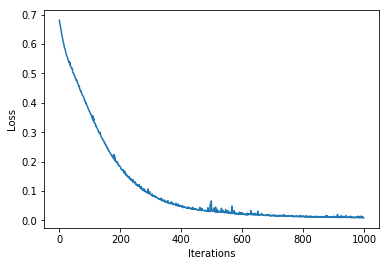

In [10]:
loss = train_pipeline.get_variable('loss')
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.plot(loss)

Save the model.

In [11]:
train_pipeline.save_model_now('my_model', path='trained_model.dill')

## Inference

Inference pipeline:

In [12]:
test_index = KNNIndex(findex.create_subset(findex.indices[40:]))
test_data = SeismicDataset(test_index)

In [23]:
config_predict = {
    'build': False,
    'load/path':  'vor.dill',
    'device': 'gpu:0'
}

test_pipeline = (test_data.p
                      .init_model('dynamic', UNet, 'my_model', config=config_predict)
                      #.import_model('my_model', train_pipeline)
                      .init_variable('true', init_on_each_run=list())
                      .init_variable('traces', init_on_each_run=list())
                      .init_variable('predictions', init_on_each_run=list())
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .standartize(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask')
                      .update_variable('true', B('mask'), mode='a')   
                      .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
                      .update_variable('traces', B('raw'), mode='a')
                      .apply_transform_all(src='mask', dst='mask', func=lambda x: np.concatenate(x)[::5, :])              
                      .add_components(components='predictions')
                      .predict_model('my_model', B('raw'), fetches='predictions',
                                       save_to=B('predictions', mode='a'))
                      .mask_to_pick(src='predictions', dst='predictions', labels=False)
                      .update_variable('predictions', B('predictions'), mode='a')
                      .dump(src='predictions', fmt='picks',path='model_predictions.csv', traces='raw', to_samples=True)
                      .run_later(1000, n_epochs=1, drop_last=False, shuffle=False, bar=True))

Run the inference pipeline on the test_dataset.   
Model results are dumped to the file **model_predictions.csv**.

In [ ]:
test_pipeline.run()

## Running time

System config:
* GPU: GTX GeForce 1080
* CPU(s): 40
* Model name: Intel Xeon E5-2630

Time performance:
* Single model training iteration with batch size=64: 0.18 sec.
* Inference iteration on the batch of 1000 traces: 0.5 sec.

## Model evaluation

Arrange results:

In [15]:
true = np.argmax(np.vstack(np.concatenate(test_pipeline.get_variable('true'))), axis=1)[::5]
pred = (np.concatenate(test_pipeline.get_variable('predictions'))).astype(float)
raw = np.vstack(np.concatenate(test_pipeline.get_variable('traces')))[::5]

Calculate metrics.

In [16]:
metrics = PickingMetrics(true, pred, gap=3)

Even though picking is a regression task, we can consider its classification interpretation as well.   
If ground truth and model predictions differs on 3 samples or more in absolute terms, then we consider such trace as not properly classified.   
The ***gap*** parameter stands for it.

#### Visual estimation.

Draw the seismogram with predictions(blue) and targets(red).

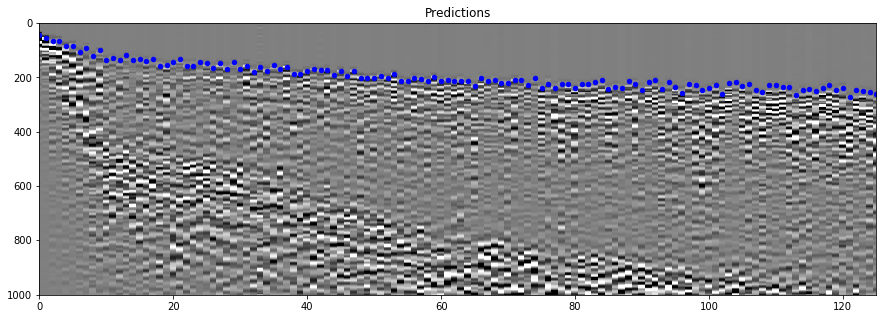

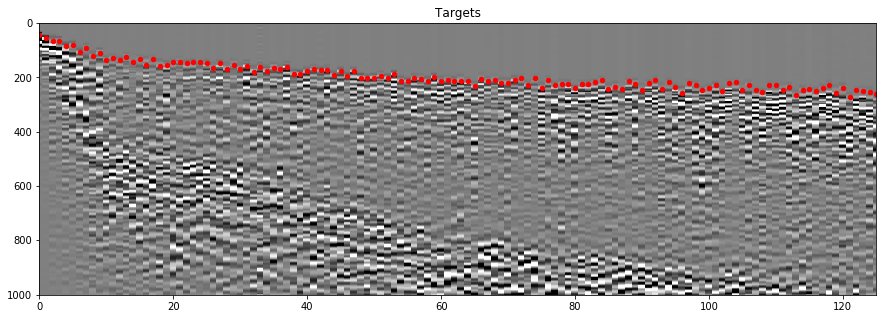

In [17]:
cv = 3
pts = (range(len(pred)), pred)
seismic_plot(raw, cmap='gray',vmax=cv, vmin=-cv, pts=pts, xlim=(0, 125),
             s=20, scatter_color='b', figsize=(15, 5), names=['Predictions'])

pts = (range(len(true)), true)
seismic_plot(raw, cmap='gray',vmax=cv, vmin=-cv, pts=pts, xlim=(0, 125),
             s=20, scatter_color='r', figsize=(15, 5), names=['Targets'])

#### Absolute error distribution.

However, take a look at the distribution of absolute error.   
In 1053 traces out of 1358 on the test data we predict picking sample to sample with targets.

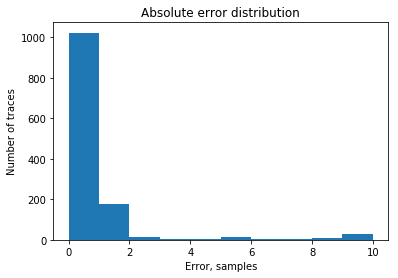

In [18]:
plt.title('Absolute error distribution')
plt.xlabel('Error, samples')
plt.ylabel('Number of traces')
_ = plt.hist(abs(true-pred), range=(0,10), bins=10)

#### MAE metrics.

Mean absolute error.

In [19]:
print('MAE on dataset 1 validation: {0:.3f}'.format(metrics.evaluate('mae')))

MAE on dataset 1 validation: 1.405


#### Accuracy metrics.

In [20]:
print('Accuracy on dataset 1 validation: {0:.2f}%'.format(metrics.evaluate('accuracy')))

Accuracy on dataset 1 validation: 89.32%


We conclude that the model trained on dataset 1  is able to find picking for traces from the same dataset.

## Criticism

#### 10 most poorly predicted traces

Take a look at 10 traces where the model mistakes the most. The traces on the plot are sorted from the right to the left. Traces on the right are the ones where the models mistakes the most.

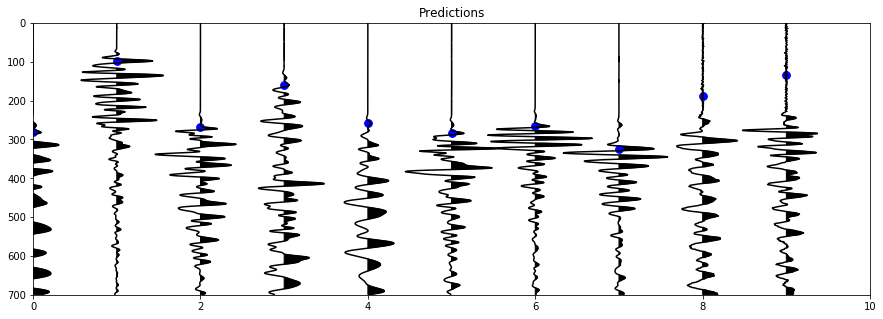

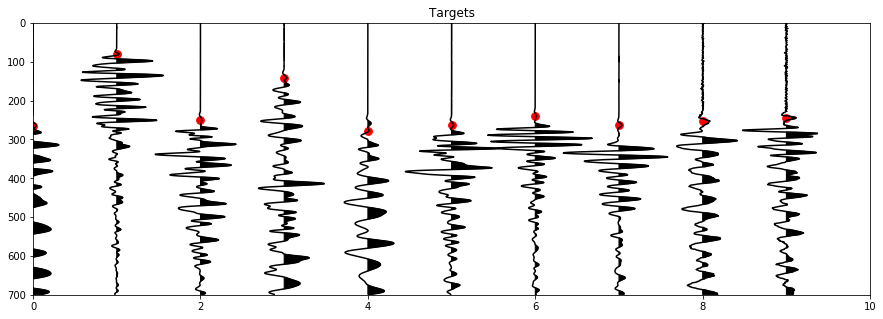

In [21]:
difference = abs(true-pred)
worst = difference.argsort()[-10:]

s = 60
std = 0.1
ylim = (0, 700)
seismic_plot(raw[worst], cmap='gray', wiggle=True, pts=(range(len(pred[worst])), pred[worst]), vmax=cv, cmin=-cv,
             figsize=(15, 5), s = s, scatter_color='b', std = std, ylim=ylim, names=['Predictions'])
seismic_plot(raw[worst], cmap='gray', wiggle=True, pts=(range(len(true[worst])), true[worst]), vmax=cv, cmin=-cv,
             figsize=(15, 5), s = s, scatter_color='r', std = std, ylim=ylim, names=['Targets'])

It can be seen that 2 most poorly predicted traces have significant noise level.   
The rest are the cases where the model skips "first" peak, which was labelled by the expert as First Break Time, and predicts the following one.

### One of the poorly predicted trace and its direct neighboors.

Take a closer look at one of the the poorly predicted traces and its direct neighboors.   
The model predicts the second peak and skips the first one.

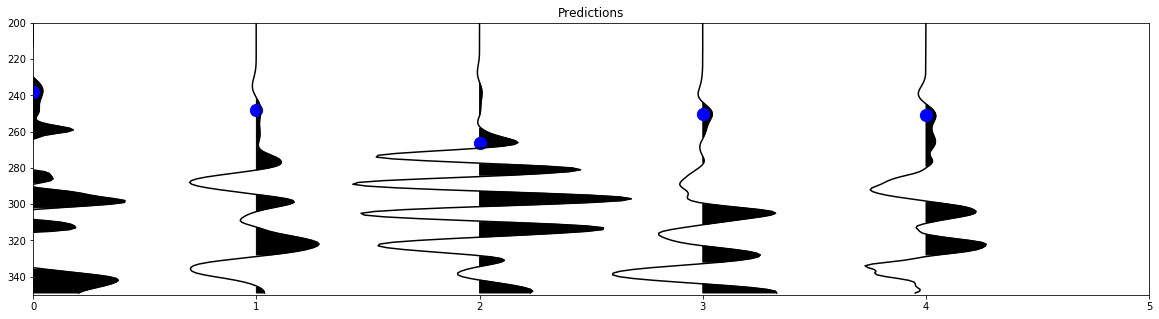

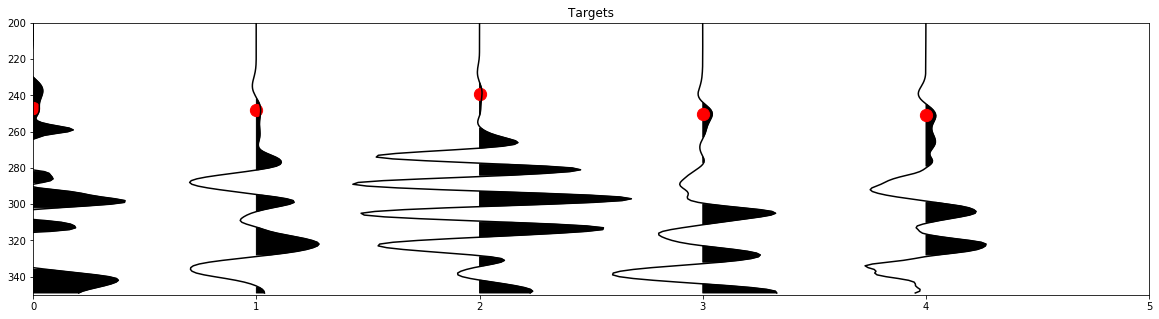

In [22]:
k = 6
nworst = [worst[k] - 2, worst[k] - 1, worst[k], worst[k] + 1, worst[k] + 2]
ylim = (200,350)
s = 150
std = 0.1
seismic_plot((raw[nworst]), cmap='gray', wiggle=True, pts=(range(len(pred[nworst])), pred[nworst]), vmax=cv, cmin=-cv,
             figsize=(20, 5), s = s, scatter_color='b', std = std, names=['Predictions'], ylim=ylim)
seismic_plot(raw[nworst], cmap='gray', wiggle=True, pts=(range(len(true[nworst])), true[nworst]), vmax=cv, cmin=-cv,
             figsize=(20, 5), s = s, scatter_color='r', std = std, names=['Targets'], ylim=ylim)

## Conclusion

The model finds first break picking, but it quite sencitive to the traces with the significant noise amplitudes before signal. Besides sometimes model skips unsignificant peaks.